In [1]:
import torch
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

import scgenome.plotting as pl

import simul
from utils.tree_utils import tree_to_newick
from tests.utils_testing import get_tree_K_nodes_one_level
from utils.config import Config, set_seed
from variational_distributions.joint_dists import FixedTreeJointDist
from variational_distributions.var_dists import qMuTau, qCMultiChrom, qZ, qEpsilonMulti, qPi
%matplotlib inline

set_seed(101)

/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/si

In [2]:
M = 500
K = 5
A = 7
N = 200
n_iter = 69
n_datasets = 2

# set params
a0 = 20.
b0 = 1000.

nu0 = 1.
lambda0 = 10.
alpha0 = 500.
beta0 = 50.
# less variable baseline
#alpha0 = 2500.
#beta0 = 50.

delta0 = 10.


simulating dataset...


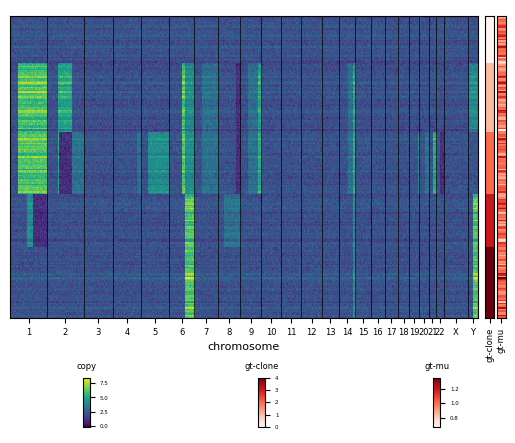

In [3]:
# simulate datasets
print("simulating dataset...")
config = Config(n_cells=N, n_nodes=K, n_states=A, chain_length=M, n_run_iter=n_iter, debug=True, step_size=0.08)
# for dsi in range(n_datasets):
fix_joint_q, sim_adata = simul.generate_dataset_var_tree(config, chrom='real', ret_anndata=True,
                                                         nu_prior=nu0, lambda_prior=lambda0, 
                                                         alpha_prior=alpha0, beta_prior=beta0,
                                                         eps_a=a0, eps_b=b0, dir_alpha=delta0)

sim_adata.obs['gt-clone'] = fix_joint_q.z.true_params['z'].numpy()
sim_adata.layers['state'] = fix_joint_q.c.true_params['c'].numpy()[sim_adata.obs['gt-clone']]
sim_adata.obs['gt-mu'] = fix_joint_q.mt.true_params['mu'].numpy()
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'copy', annotation_fields=['gt-clone', 'gt-mu'], cell_order_fields=['gt-clone'], raw=True)

Fig: simulated reads together with true clustering and baseline.

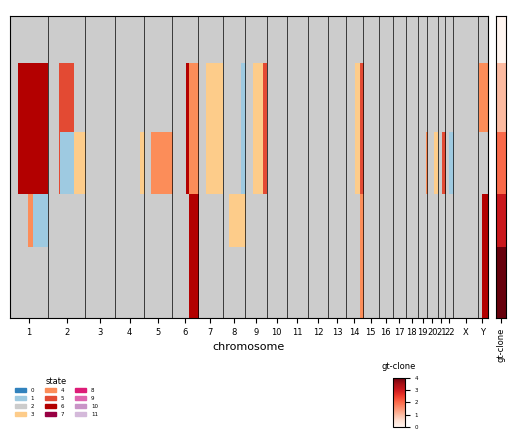

In [4]:
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'state', annotation_fields=['gt-clone'], cell_order_fields=['gt-clone'], max_cn=config.n_states)

Fig. True copy number signal for each cluster.

In [5]:
# set up qmt, cell-qc
cell_config = Config(n_cells=N, n_nodes=N+1, n_states=A, n_run_iter=n_iter, step_size=0.2,
                     chain_length=config.chain_length, chromosome_indexes=config.chromosome_indexes, debug=True)
cell_qmt = qMuTau(cell_config, nu_prior=1., lambda_prior=1000., alpha_prior=50000., beta_prior=500.)
cell_qmt.initialize(method='prior')

cell_qc = qCMultiChrom(cell_config)
cell_qc.initialize(method='diploid')

cell_qeps = qEpsilonMulti(cell_config, alpha_prior=1., beta_prior=10.)
cell_qeps.initialize(method='fixed-equal', eps_alpha=cell.config.chain_length / 100, eps_beta=cell.config.chain_length)

SyntaxError: keyword argument repeated: eps_alpha (1153076870.py, line 11)

In [ ]:
# run inference with qmt,cell-qc
fixed_z = torch.arange(1, N + 1)
cell_qz_fix = qZ(cell_config, true_params={'z': fixed_z})
cell_tree = get_tree_K_nodes_one_level(N + 1)

print("running inference...")
for i in range(n_iter):
    cell_qmt.update(cell_qc, cell_qz_fix, fix_joint_q.obs)
    cell_qc.update(fix_joint_q.obs, cell_qeps, cell_qz_fix, cell_qmt,
                   [cell_tree], [1.])
    cell_qeps.update([cell_tree], torch.tensor([1.]), cell_qc)
    if (i+1) % 10 == 0:
        print(f"it {i}, elbo {cell_qc.compute_elbo([cell_tree], [1.], q_eps=cell_qeps)}")


In [ ]:
# after inference on cells specific cn
sim_adata.layers['cell-cn'] = cell_qc.get_viterbi()[1:].numpy()
sim_adata.obs['init-mu'] = cell_qmt.nu.numpy()
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'cell-cn', annotation_fields=['gt-clone', 'init-mu', 'gt-mu'], cell_order_fields=['gt-clone'], max_cn=config.n_states)

Fig. Cell-specific copy number profile when qMuTau and cell-qC are jointly inferred for initialization

In [ ]:
print("running k-means")
# cluster copy numbers with kmeans (on viterbi)
kmeans = KMeans(n_clusters=K, random_state=0).fit(cell_qc.get_viterbi()[1:])
c_labels = kmeans.labels_

print(f"ARI for KMeans after cell-cn estimation: {adjusted_rand_score(c_labels, fix_joint_q.z.true_params['z'].numpy())}")

# cluster copy numbers with kmeans (on viterbi)
obs_kmeans = KMeans(n_clusters=K, random_state=0).fit(fix_joint_q.obs.T.numpy())
obs_labels = obs_kmeans.labels_

print(f"ARI for KMeans with obs: {adjusted_rand_score(obs_labels, fix_joint_q.z.true_params['z'].numpy())}")


In [ ]:
# initialize new qc with average
# build eta1 and eta2 from cell_qc
qc = qCMultiChrom(config)

for i, chr_qc in enumerate(qc.qC_list):
    # init for each chromosome the average tensor
    avg_param = {'eta1': torch.empty_like(chr_qc.eta1), 'eta2': torch.empty_like(chr_qc.eta2)}
    for k in range(K):
        cells_k = c_labels == k
        # average of eta parameters over cells assigned to the same cluster
        avg_param['eta1'][k, ...] = cell_qc.qC_list[i].eta1[1:][cells_k].mean(dim=0)
        avg_param['eta2'][k, ...] = cell_qc.qC_list[i].eta2[1:][cells_k].mean(dim=0)
    # normalization step
    avg_param['eta1'] = avg_param['eta1'] - torch.logsumexp(avg_param['eta1'], dim=-1, keepdim=True)
    avg_param['eta2'] = avg_param['eta2'] - torch.logsumexp(avg_param['eta2'], dim=-1, keepdim=True)

    chr_qc.initialize(method='fixed', **avg_param)

In [ ]:
# inspect current state of new qC
sim_adata.layers['init-state'] = qc.get_viterbi().numpy()[sim_adata.obs['gt-clone']]
sim_adata.obs['kmeans'] = c_labels
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'init-state', annotation_fields=['gt-clone', 'kmeans'], cell_order_fields=['gt-clone'], max_cn=config.n_states)

In [ ]:
stable_zero = 1e-2
# initialize new qz (with current clustering) and new qeps
qz = qZ(config)
pi_init = torch.nn.functional.one_hot(torch.tensor(c_labels).long(), num_classes=config.n_nodes)
pi_init_smooth = torch.empty_like(pi_init, dtype=torch.float)
pi_init_smooth[pi_init == 1] = 1 - stable_zero
pi_init_smooth[pi_init == 0] = stable_zero / (config.n_nodes - 1)
# qz.initialize(z_init='fixed', pi_init=pi_init)
qz.initialize(z_init='fixed', pi_init=pi_init_smooth)

qpi = qPi(config)
cell_counts = np.unique(c_labels, return_counts=True)[1]
concentration_param_init = torch.tensor(cell_counts)
qpi.initialize(method='fixed', concentration_param_init=concentration_param_init)

qeps = qEpsilonMulti(config, alpha_prior=a0, beta_prior=b0)
qeps.initialize(method='prior')

qmt = qMuTau(config, nu_prior=1., lambda_prior=10., alpha_prior=50., beta_prior=5.)
qmt.initialize(method='fixed', loc=cell_qmt.nu, precision_factor=cell_qmt.lmbda, shape=cell_qmt.alpha, rate=cell_qmt.beta)

In [ ]:
print("few more updates for qc and qmt after clustering...")
treeK = get_tree_K_nodes_one_level(config.n_nodes)

for i in range(100):
    qc.update(fix_joint_q.obs, qeps, qz, qmt, [treeK], [1.])
    qeps.update([treeK], [1.], qc)
    qmt.update(qc, qz, fix_joint_q.obs)

In [ ]:
sim_adata.obs['vi-clone'] = qz.pi.argmax(dim=-1).numpy()
sim_adata.layers['vi-state'] = qc.get_viterbi().numpy()[sim_adata.obs['vi-clone']]
sim_adata.obs['vi-mu'] = qmt.nu.numpy()

# analyze eps
eps_mean_K = [qeps.mean()[0,k].item() for k in range(1, config.n_nodes)]
eps_mean_K = np.array([0.] + eps_mean_K)
sim_adata.obs['star-eps'] = eps_mean_K[sim_adata.obs['vi-clone']]

g = pl.plot_cell_cn_matrix_fig(sim_adata, 'vi-state', annotation_fields=['gt-clone', 'vi-clone', 'gt-mu', 'vi-mu', 'star-eps'], cell_order_fields=['vi-clone'], max_cn=7)

In [ ]:
print("running inference post init...")
joint = FixedTreeJointDist(config, qc, qz, qeps, qmt, qpi, treeK, fix_joint_q.obs)
for i in range(100):
    joint.update(it = i)
    if (i+1) % 10 == 0:
        print(f"it {i}, elbo {joint.elbo}")
        

In [ ]:
sim_adata.obs['vi-clone'] = qz.pi.argmax(dim=-1).numpy()
sim_adata.layers['vi-state'] = qc.get_viterbi().numpy()[sim_adata.obs['vi-clone']]
sim_adata.obs['vi-mu'] = qmt.nu.numpy()
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'vi-state', annotation_fields=['gt-clone', 'vi-clone', 'gt-mu', 'vi-mu'], cell_order_fields=['gt-clone'], max_cn=7)

## ISSUE

No cells are assigned to the healthy clone, and similar clusters are confounded.
When running qMuTau and cell-qC jointly in the beginning, it's easy for the algorithm
to find optima in mu that are smaller/larger than the true mu, while offsetting the
copy number accordingly. This can be avoided by using HMMcopy profile instead as an
initialization step.

## one solution...
Setting a hard prior on the initial cell_qmt (1., 100., 10000., 500.) results in a perfect
output both in terms of copy number and clustering (perfect initial clustering coming from
the cell-specific copy number profile.

## Tree inference
We now inspect the resulting epsilon values and from those, we try to infer the tree
The true tree being {{ tree_to_newick(fix_joint_q.t.true_params['tree']) }}